In [7]:
import glob
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.ndimage.measurements import label
from tqdm import *
from lesson_functions import *

%matplotlib inline

## Load classifier

In [8]:
clf = pickle.load(open('svc.p','rb'))

In [96]:
img_files_list = ['test1.jpg','test4.jpg','test6.jpg']
img = mpimg.imread('./test_images/' + img_files_list[2])

## Setting parameters (constant values)

In [97]:
ORIENT = 9
PIX_PER_CELL = 8
YSTART = 400
YSTOP = 700
SCALE = 1.5
CELL_PER_BLOCK = 2
SPATIAL_SIZE = (32, 32)
HIST_BINS = 32

In [98]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[YSTART:YSTOP,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/SCALE), np.int(imshape[0]/SCALE)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // PIX_PER_CELL) - CELL_PER_BLOCK + 1
    nyblocks = (ch1.shape[0] // PIX_PER_CELL) - CELL_PER_BLOCK + 1 
    nfeat_per_block = ORIENT*CELL_PER_BLOCK**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // PIX_PER_CELL) - CELL_PER_BLOCK + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    hog2 = get_hog_features(ch2, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    hog3 = get_hog_features(ch3, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, feature_vec=False)
    
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*PIX_PER_CELL
            ytop = ypos*PIX_PER_CELL

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=SPATIAL_SIZE)
            hist_features = color_hist(subimg, nbins=HIST_BINS)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+YSTART),(xbox_left+win_draw,ytop_draw+win_draw+YSTART),(0,0,255),6) 
#                 box_list.append(((xbox_left, ytop_draw+YSTART),(xbox_left+win_draw,ytop_draw+win_draw+YSTART)))
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*SCALE)
                ytop_draw = np.int(ytop*SCALE)
                win_draw = np.int(window*SCALE)
                box_list.append(((xbox_left, ytop_draw+YSTART),(xbox_left+win_draw,ytop_draw+win_draw+YSTART)))
                
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
#     # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    return draw_img

In [99]:
out_img = find_cars(img)

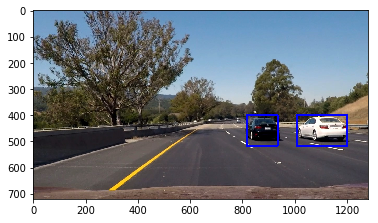

In [100]:
plt.imshow(out_img);

In [103]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(find_cars)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 148/1261 [08:03<58:49,  3.17s/it]


 24%|██▎       | 299/1261 [16:04<51:01,  3.18s/it]


 36%|███▌      | 450/1261 [24:02<42:54,  3.17s/it]


 48%|████▊     | 601/1261 [32:27<35:21,  3.21s/it]


 60%|█████▉    | 752/1261 [40:27<27:01,  3.18s/it]


 72%|███████▏  | 903/1261 [48:20<18:32,  3.11s/it]


 84%|████████▎ | 1053/1261 [56:08<10:49,  3.12s/it]


 95%|█████████▌| 1199/1261 [1:03:48<03:36,  3.49s/it]


100%|█████████▉| 1260/1261 [1:07:16<00:03,  3.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 11min 33s, sys: 2.54 s, total: 1h 11min 35s
Wall time: 1h 7min 16s
